In [3]:

# ================================
# CREDIT CARD FRAUD Detection - FULL PYTHON SCRIPT
# ================================

# --- Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------
# Step 1: Load CSV
# ------------------------
file_path = "C:/ProgramData/MySQL/MySQL Server 8.0/Uploads/Credit Card Fraud Risk Analysis.csv"
df = pd.read_csv(file_path)

# Strip extra spaces in column names
df.columns = df.columns.str.strip()

# Quick overview
print("Columns:", df.columns.tolist())
print(df.head())
print(df.info())
print(df.isnull().sum())

# ------------------------
# Step 2: Convert Dates
# ------------------------
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'], errors='coerce')

# ------------------------
# Step 3: Convert Numeric Columns
# ------------------------
df['Transaction Amount (INR)'] = pd.to_numeric(df['Transaction Amount (INR)'], errors='coerce')
df['Fraud Score'] = pd.to_numeric(df['Fraud Score'], errors='coerce')
df['IsFraud'] = pd.to_numeric(df['IsFraud'], errors='coerce')

# ------------------------
# Step 4: Handle Missing Values
# ------------------------
df['Transaction Amount (INR)'].fillna(df['Transaction Amount (INR)'].median(), inplace=True)
df['Fraud Score'].fillna(df['Fraud Score'].median(), inplace=True)
df['IsFraud'].fillna(0, inplace=True)  # Assume missing fraud flag = not fraud

# ------------------------
# Step 5: Save Cleaned Data
# ------------------------
df = df.drop_duplicates(subset=['Transaction ID'])  # Ensure unique transactions
df = df.reset_index(drop=True)
cleaned_file_path = "C:/ProgramData/MySQL/MySQL Server 8.0/Uploads/credit_card_fraud_cleaned.csv"
df.to_csv(cleaned_file_path, index=False)
print("✅ Cleaned CSV saved successfully!")

Columns: ['Transaction ID', 'Customer Name', 'Merchant Name', 'Transaction Date', 'Transaction Amount (INR)', 'Fraud Risk', 'Fraud Type', 'State', 'Card Type', 'Bank', 'IsFraud', 'Fraud Score', 'Transaction Category', 'Merchant Location']
   Transaction ID  Customer Name Merchant Name Transaction Date  \
0        17797619     Pihu Manne          Uber       2024-11-10   
1        50040671   Hiran Vaidya        Zomato       2024-05-20   
2        88177651     Shalv Vasa        Myntra       2024-05-28   
3        24228305  Taran Shanker     Lifestyle       2024-01-09   
4        87307869   Shanaya Kara     Tata Cliq       2024-07-27   

   Transaction Amount (INR) Fraud Risk        Fraud Type          State  \
0                     11673     Medium  Card Not Present      Telangana   
1                     16594     Medium          Phishing    Maharashtra   
2                     23347     Medium     Card Skimming  Uttar Pradesh   
3                     20753        Low     Card Skimming  

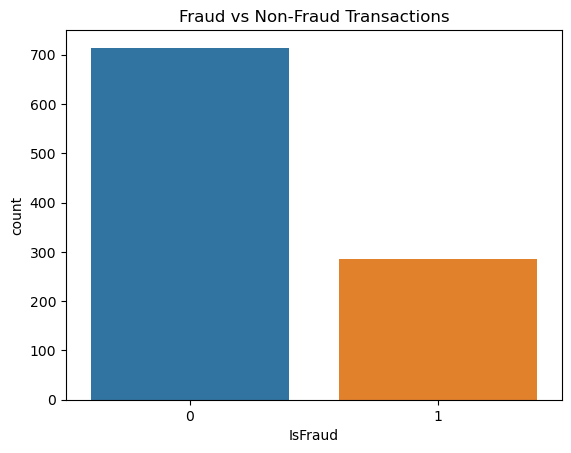

Fraud Percentage Distribution:
 IsFraud
0    71.4
1    28.6
Name: proportion, dtype: float64


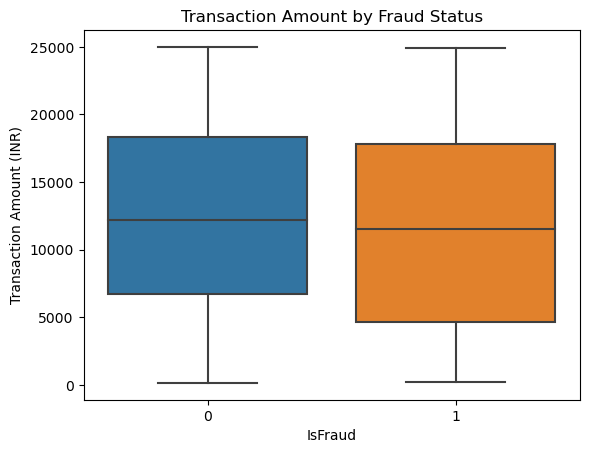

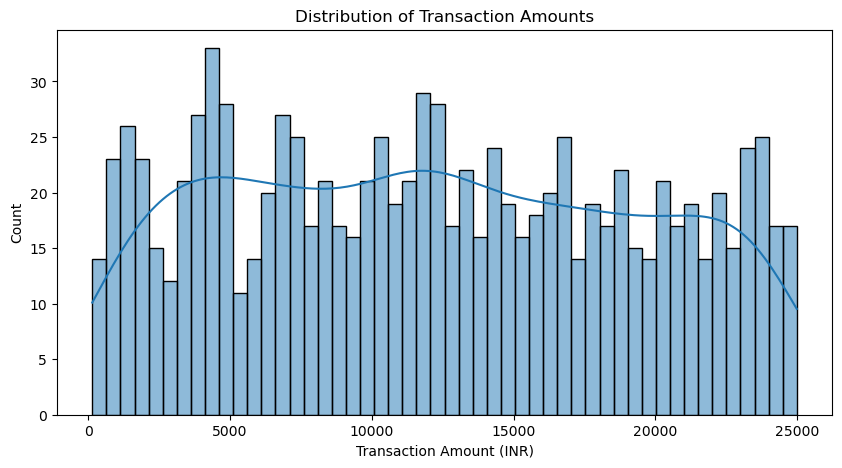

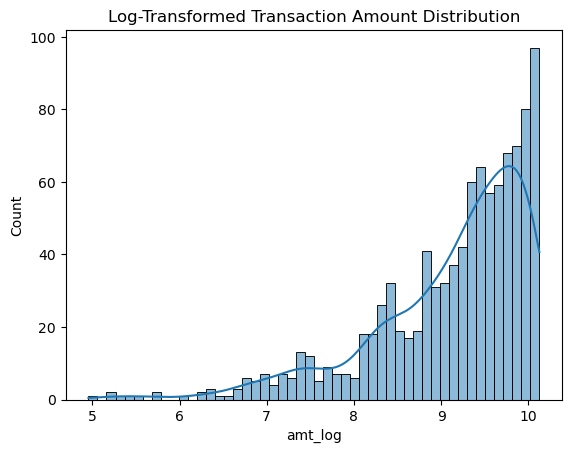

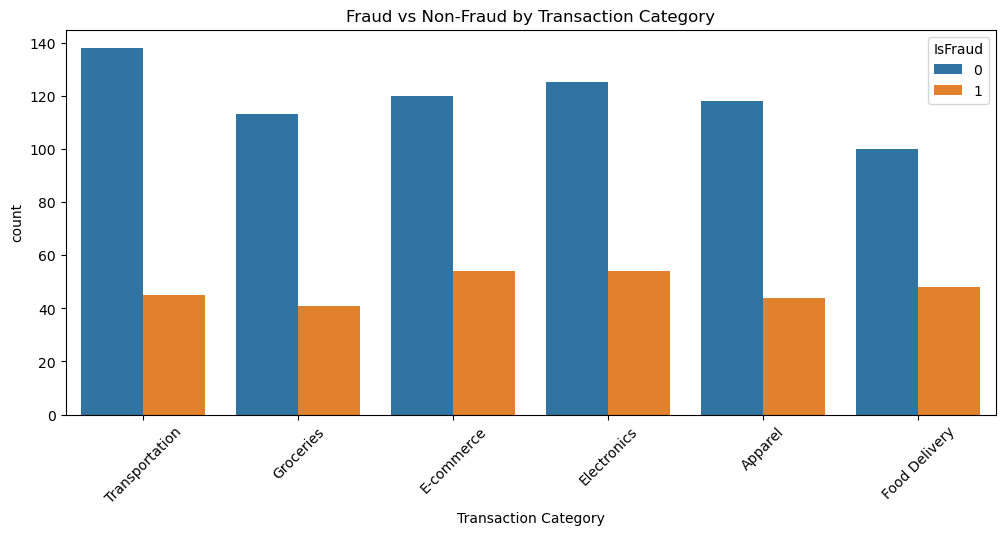

Fraud Ratio by Category:
 Transaction Category
Food Delivery     0.324324
E-commerce        0.310345
Electronics       0.301676
Apparel           0.271605
Groceries         0.266234
Transportation    0.245902
Name: IsFraud, dtype: float64


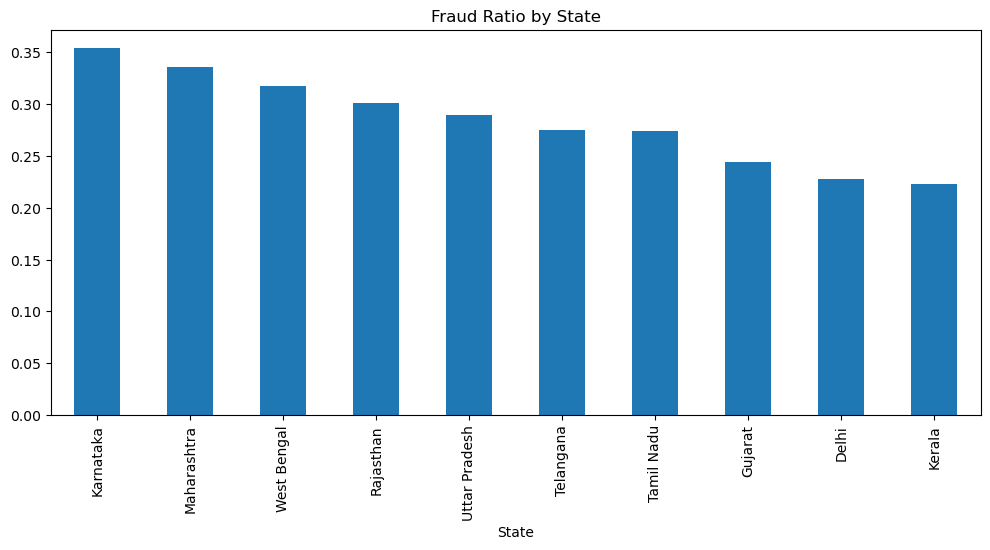

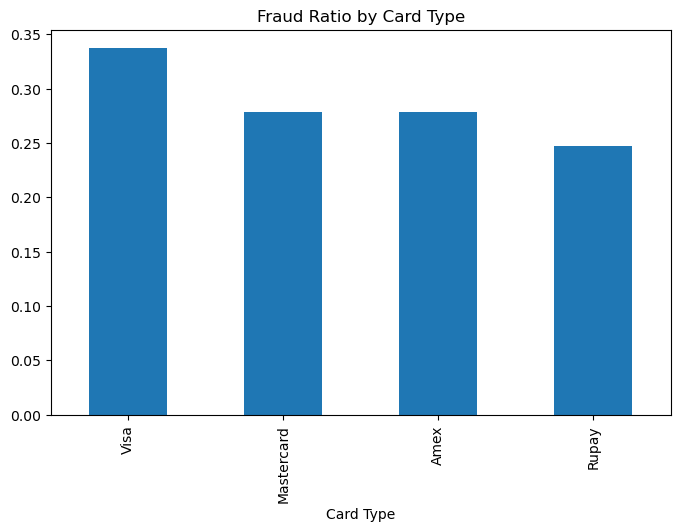

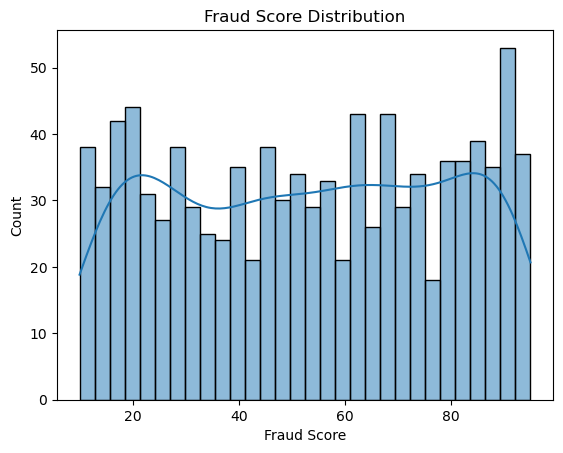

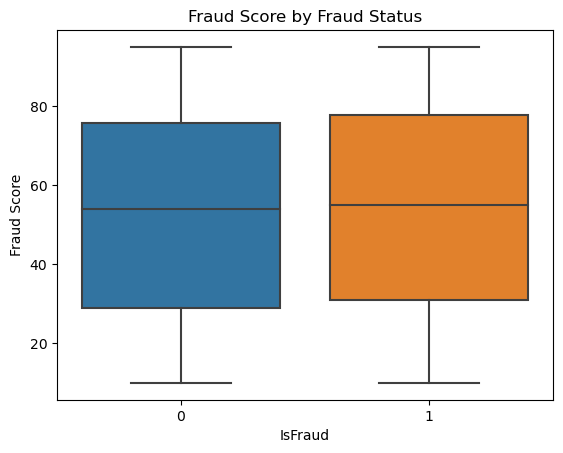

In [4]:
# ================================
# Exploratory Data Analysis (EDA)
# ================================

# --- Fraud vs Non-Fraud Transactions ---
sns.countplot(x='IsFraud', data=df)
plt.title("Fraud vs Non-Fraud Transactions")
plt.show()

fraud_percentage = df['IsFraud'].value_counts(normalize=True) * 100
print("Fraud Percentage Distribution:\n", fraud_percentage)

# --- Transaction Amount Analysis ---
sns.boxplot(x='IsFraud', y='Transaction Amount (INR)', data=df)
plt.title("Transaction Amount by Fraud Status")
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(df['Transaction Amount (INR)'], bins=50, kde=True)
plt.title("Distribution of Transaction Amounts")
plt.show()

# Log transformation for skewed amounts
df['amt_log'] = np.log1p(df['Transaction Amount (INR)'])
sns.histplot(df['amt_log'], bins=50, kde=True)
plt.title("Log-Transformed Transaction Amount Distribution")
plt.show()

# --- Fraud by Category ---
plt.figure(figsize=(12,5))
sns.countplot(x='Transaction Category', hue='IsFraud', data=df)
plt.xticks(rotation=45)
plt.title("Fraud vs Non-Fraud by Transaction Category")
plt.show()

fraud_by_category = df.groupby('Transaction Category')['IsFraud'].mean().sort_values(ascending=False)
print("Fraud Ratio by Category:\n", fraud_by_category)

# --- Fraud by State ---
fraud_by_state = df.groupby('State')['IsFraud'].mean().sort_values(ascending=False)
fraud_by_state.plot(kind='bar', figsize=(12,5))
plt.title("Fraud Ratio by State")
plt.show()

# --- Fraud by Card Type ---
fraud_by_card = df.groupby('Card Type')['IsFraud'].mean().sort_values(ascending=False)
fraud_by_card.plot(kind='bar', figsize=(8,5))
plt.title("Fraud Ratio by Card Type")
plt.show()

# --- Fraud Score Analysis ---
sns.histplot(df['Fraud Score'], bins=30, kde=True)
plt.title("Fraud Score Distribution")
plt.show()

sns.boxplot(x='IsFraud', y='Fraud Score', data=df)
plt.title("Fraud Score by Fraud Status")
plt.show()


In [3]:
# ================================
# Summary Statistics for Dashboard
# ================================
summary = {
    "Total Transactions": df.shape[0],
    "Total Transaction Amount": df['Transaction Amount (INR)'].sum(),
    "Fraud Transactions": int(df['IsFraud'].sum()),
    "Non-Fraud Transactions": int(df.shape[0] - df['IsFraud'].sum()),
    "Average Fraud Score": df['Fraud Score'].mean()
}

summary_df = pd.DataFrame([summary])
summary_df.to_csv("fraud_summary.csv", index=False)
print("✅ Summary exported to fraud_summary.csv")
print(summary_df)

✅ Summary exported to fraud_summary.csv
   Total Transactions  Total Transaction Amount  Fraud Transactions  \
0                1000                  12226843                 286   

   Non-Fraud Transactions  Average Fraud Score  
0                     714               53.179  


In [5]:
# ML imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


In [6]:
# -------------------
# FEATURE ENGINEERING
# -------------------

# Drop Transaction ID and Customer Name (not useful)
df = df.drop(["Transaction ID", "Customer Name"], axis=1)

# Convert Transaction Date to datetime
df["Transaction Date"] = pd.to_datetime(df["Transaction Date"], errors='coerce')

# Extract time-based features
df["Hour"] = df["Transaction Date"].dt.hour
df["Day"] = df["Transaction Date"].dt.day
df["Month"] = df["Transaction Date"].dt.month
df["Weekday"] = df["Transaction Date"].dt.weekday

# High value transaction flag
df["HighValueFlag"] = (df["Transaction Amount (INR)"] > 100000).astype(int)

# Interaction feature
df["Amount_Score_Interaction"] = df["Transaction Amount (INR)"] * df["Fraud Score"]

# Encode categorical variables
cat_cols = ["Merchant Name", "Fraud Risk", "Fraud Type", 
            "State", "Card Type", "Bank", 
            "Transaction Category", "Merchant Location"]

le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))

In [7]:
# -------------------
# TRAIN-TEST SPLIT
# -------------------
X = df.drop(["IsFraud", "Transaction Date"], axis=1)
y = df["IsFraud"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [8]:
# -------------------
# 1. Logistic Regression (Baseline)
# -------------------
log_model = LogisticRegression(class_weight='balanced', max_iter=1000)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
y_pred_prob_log = log_model.predict_proba(X_test)[:,1]

print("=== Logistic Regression ===")
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob_log))


=== Logistic Regression ===
[[98 45]
 [34 23]]
              precision    recall  f1-score   support

           0       0.74      0.69      0.71       143
           1       0.34      0.40      0.37        57

    accuracy                           0.60       200
   macro avg       0.54      0.54      0.54       200
weighted avg       0.63      0.60      0.61       200

ROC-AUC Score: 0.5350263771316403


In [9]:
# -------------------
# 2. Random Forest (Better Model)
# -------------------
rf_model = RandomForestClassifier(
    n_estimators=200, random_state=42, class_weight='balanced'
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)[:,1]

print("\n=== Random Forest ===")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob_rf))


=== Random Forest ===
[[140   3]
 [ 55   2]]
              precision    recall  f1-score   support

           0       0.72      0.98      0.83       143
           1       0.40      0.04      0.06        57

    accuracy                           0.71       200
   macro avg       0.56      0.51      0.45       200
weighted avg       0.63      0.71      0.61       200

ROC-AUC Score: 0.474481658692185


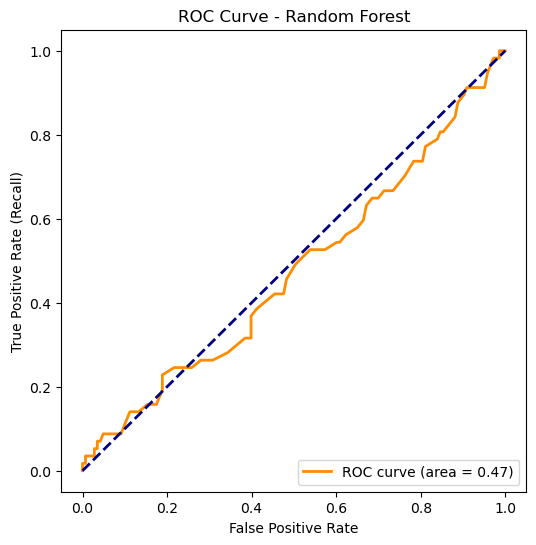

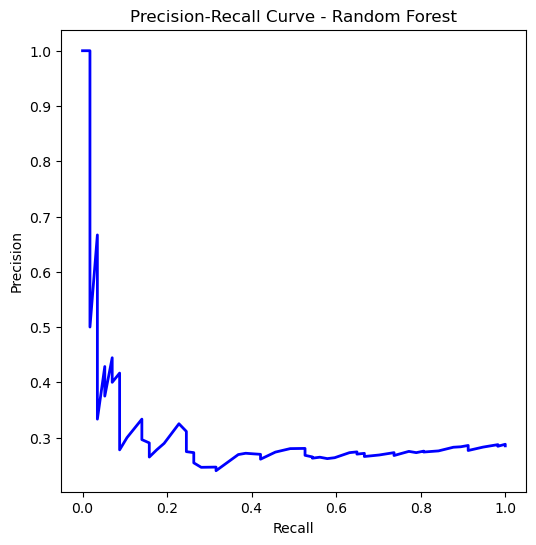

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve - Random Forest")
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob_rf)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Random Forest")
plt.show()
